<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: Павел Прохоров (@pavelvpster)

# SVM (Support Vector Machine)

## Совсем немного теории

SVM (Support Vector Machine, Машина Опорных Векторов) относится к классу алгоритмов обучения с учителем. Принадлежит семейству линейных алгоритмов классификации с максимальным зазором.

Вспомним задачу бинарной классификации...

### Жесткий зазор (hard-margin)

Если данные являются линейно разделимыми, можно построить такую разделяющую гиперплоскость, которая максимизирует расстояние между двумя параллельными гиперплоскостями (изображение взято из статьи https://en.wikipedia.org/wiki/Support_vector_machine):

<img src="../../img/svm_max_sep_hyperplane_with_margin.png" alt="Разделяющая гиперплоскость" style="width: 300px;"/>

Каждая точка данных должна находится на "правильной" стороне от разделяющей гиперплоскости.

Это условие можно записать так:

$$ y_{i} (w^T x_i - b) \geqslant 1, i = 1..n $$

где

$ y $ - метки целевого класса +1 или -1

$ x $ - признаки (каждый признак это вектор)

$ w $ - коэффициенты модели (каждый коэффициент тоже вектор)

Тогда задача построения разделяющей гиперплоскости формулируется так:

$$ \begin{cases} \frac{1}{2} w^T w \to min \\ y_{i} (w^T x_i - b) \geqslant 1, i = 1..n \end{cases} $$

Ближайшие к гиперплоскостям точки называются опорными векторами. Их достаточно для построения модели, все точки не нужны.

### Мягкий зазор (soft-margin)

Если данные не являются линейно разделимыми, часть точек окажется на "неправильной" стороне.

Минимизировать надо функцию потерь. В SVM используется петлевая функция потерь [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss):

$$ \zeta_i = max(0, 1 - y_{i} (w^T x_i - b)) $$

Значение функции потерь равно 0, если точка находится на правильной стороне разделяющей гиперплоскости и пропорционально расстоянию до разделяющей гиперплоскости, если точка находится на неправильной стороне.

На следующем графике приведены zero-one-loss, hinge loss, squared hinge loss:

<img src="../../img/svm_loss_functions.png" alt="Функции потерь" style="width: 400px;"/>

Squared hinge loss используется потому, что производная от hinge loss в точке $ y_{i} (w^T x_i - b) = 1 $ не определена.

Задача построения разделяющей гиперплоскости:

$$ \begin{cases} \frac{1}{2} w^T w + C \sum_{i=1}^n \zeta_i \to min \\ y_{i} (w^T x_i - b) \geqslant 1 - \zeta_i , \zeta_i \geqslant 0, i = 1..n \end{cases} $$

где $ C $ определяет соотношение между целями максимизации зазора и уменьшения ошибки.

### Нелинейный случай

Если данные не являются линейно разделимыми, можно попробовать выбрать пространство более высокой размерности в котором они будут линейно разделимыми.

Это означает, что в формулах $ x_i $ надо заменить на функцию $ \phi(x_i) $:

$$ \begin{cases} \frac{1}{2} w^T w + C \sum_{i=1}^n \zeta_i \to min \\ y_{i} (w^T \phi(x_i) - b) \geqslant 1 - \zeta_i , \zeta_i \geqslant 0, i = 1..n \end{cases} $$

Однако, вычислять значение $ \phi(x_i) $ не потребуется.

Запишем вектор коэффициентов $ w $ как линейную комбинацию опорных векторов:

$$ w = \sum_{i=0}^l y_i \alpha_i \phi(x_i) $$

Тогда произведение $ w^T x $ примет вид:

$$ w^T x = \sum_{i=0}^l y_i \alpha_i \phi(x_i) \cdot \phi(x) = \sum_{i=0}^l y_i \alpha_i K(x_i, x) $$

где $K$ - функция ядра.

В библиотеке scikit-learn предлагаются следуюшие функции ядра:

- линейную (linear): $ K(x,x') = \langle x, x' \rangle $
- полиномиальную (polynomial): $ K(x,x') = (\gamma \langle x, x' \rangle + r)^d $
- RBF: $ K(x,x') = e^{-\gamma || x - x' ||^2} $
- сигмоид (sigmoid): $ K(x,x') = tanh(\gamma \langle x, x' \rangle + r) $

Вот такой вот [kernel method](https://en.wikipedia.org/wiki/Kernel_method)

Но хватит, теории - займемся практикой...

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC

## Простой пример

Для начала классы будут линейно разделимыми.

Подготовим данные: два облака точек (красные и синие) с нормальным распределением координат.

In [2]:
A = 50
B = 200

X_1 = pd.DataFrame({'x': np.concatenate([np.random.normal(2, 0.5, A), np.random.normal(5, 0.5, B)]),
                    'y': np.concatenate([np.random.normal(2, 0.5, A), np.random.normal(5, 0.5, B)])})

X_1.head()

,x,y
0,2.232925,2.555276
1,2.001144,1.993692
2,1.774639,1.912163
3,2.359637,2.070895
4,2.253835,2.277883


In [3]:
Y_1 = pd.DataFrame({'target': np.concatenate([np.repeat(0, A), np.repeat(1, B)])})

Y_1['target'].value_counts()

1    200
0     50
Name: target, dtype: int64

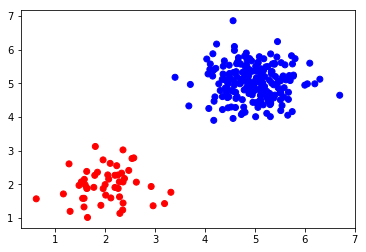

In [4]:
plt.scatter(X_1.x, X_1.y, c=['red' if y == 0 else 'blue' if y == 1 else 'black' for y in Y_1.target])

plt.show()

### Полезные функции для отображения границ

Код функций `make_meshgrid` и `plot_contours` заимствован из [примера к библиотеке scikit-learn](http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html#sphx-glr-auto-examples-svm-plot-iris-py)

In [5]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

In [6]:
def plot_contours(ax, classifier, xx, yy, **params):
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [7]:
def compare_and_plot(X, Y):
    
    classifiers = [LogisticRegression(), LinearSVC(), SVC(kernel='poly'), SVC(kernel='rbf')]
    
    for classifier in classifiers:
        classifier.fit(X, Y)
    
    classifier_names = ['Logistic Regression', 'SVM (Linear Kernel)', 'SVM (Polynomial Kernel)', 'SVM (RBF Kernel)']
    
    color = ['red' if y == 0 else 'blue' if y == 1 else 'black' for y in Y.target]
    
    xx, yy = make_meshgrid(X.x, X.y)
    
    fig, sub = plt.subplots(2, 2, figsize=(15,15))
    
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    for name, classifier, ax in zip(classifier_names, classifiers, sub.flatten()):
        
        plot_contours(ax, classifier, xx, yy, cmap='summer', alpha=0.25)
        
        ax.scatter(X.x, X.y, c=color)
        
        predictions = classifier.predict(X)
        acc = accuracy_score(Y, predictions)
        
        ax.set_title('{}. Accuracy={}'.format(name, acc))
    

### Построим границы классификации

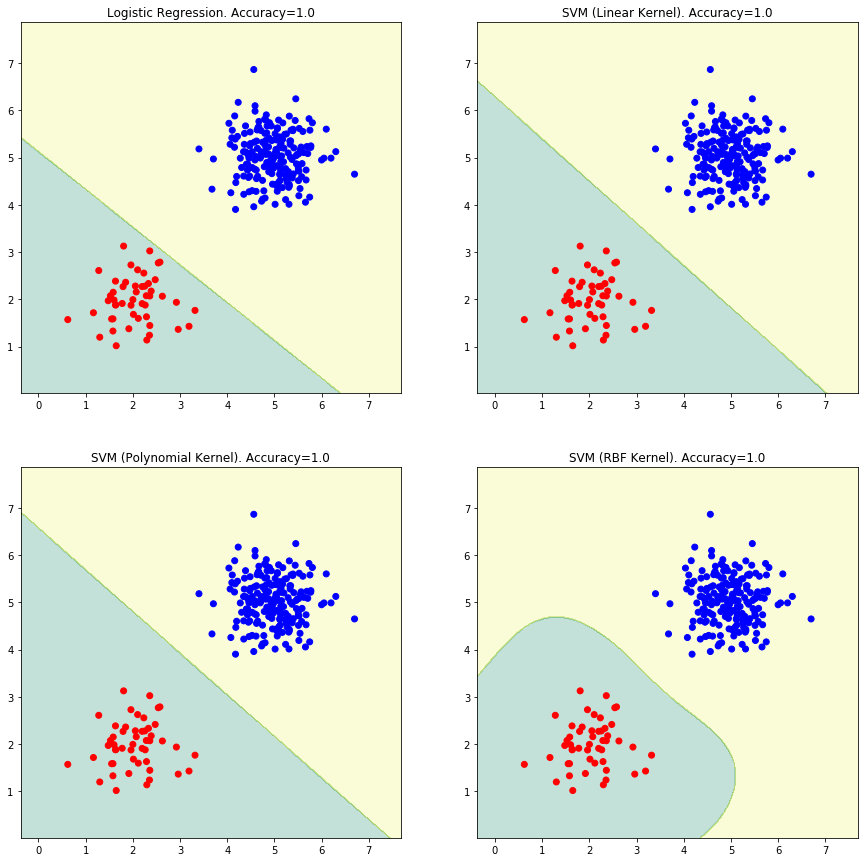

In [8]:
compare_and_plot(X_1, Y_1)

### Какие выводы можно сделать по этим графикам?

1. Логистическая регрессия оценивает вероятность принадлежности к классу. Поэтому граница дальше от облака синих точек: их больше, значит для какой-либо точки (новой) вероятность быть отнесенной к синим точкам больше.

2. SVM с линейным и полиномиальным ядрами проводит границу на одинаковом расстоянии между классами.

3. SVM с RBF ядром формирует границу сложной формы (понадобится для случая, когда классы не являются линейно разделимыми).


## Пример посложнее

Теперь рассмотрим случай, когда классы не являются линейно разделимыми.

In [9]:
X_2 = pd.DataFrame({'x': np.concatenate([np.random.normal(2, 1.5, A), np.random.normal(5, 1.5, B)]),
                    'y': np.concatenate([np.random.normal(2, 1.5, A), np.random.normal(5, 1.5, B)])})

X_2.head()

,x,y
0,2.366682,3.469960
1,0.077342,1.978226
2,0.798090,1.886079
3,3.561054,0.630126
4,1.352622,2.987067


In [10]:
Y_2 = pd.DataFrame({'target': np.concatenate([np.repeat(0, A), np.repeat(1, B)])})

Y_2['target'].value_counts()

1    200
0     50
Name: target, dtype: int64

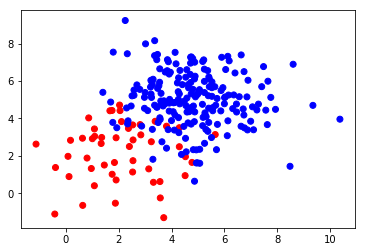

In [11]:
plt.scatter(X_2.x, X_2.y, c=['red' if y == 0 else 'blue' if y == 1 else 'black' for y in Y_2.target])

plt.show()

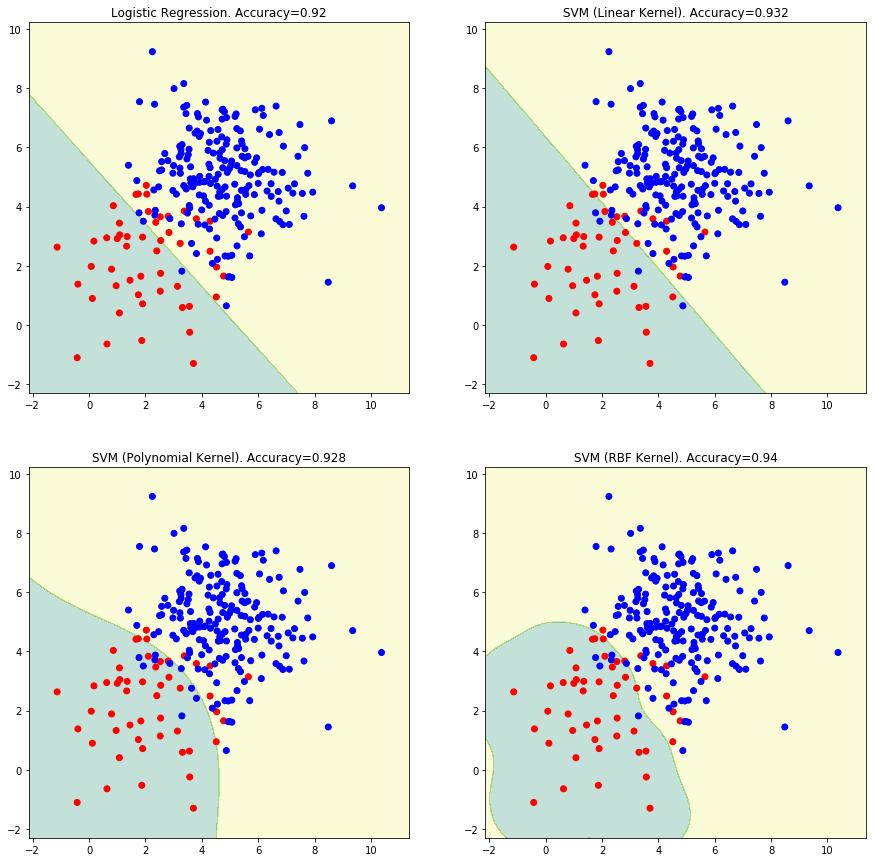

In [12]:
compare_and_plot(X_2, Y_2)

### Выводы

1. Граница у SVM с полиномиальным ядром стала сложнее.

2. Масимальную точность показала SVM с ядром RBF.


## Совсем сложный пример

In [13]:
X_3 = pd.DataFrame({'x': np.random.normal(5, 2.0, 250),
                    'y': np.random.normal(5, 2.0, 250)})

X_3.head()

,x,y
0,7.832353,0.653481
1,1.463369,3.381065
2,4.306100,7.123228
3,-0.026838,3.824152
4,7.436514,1.713203


In [14]:
Y_3 = pd.DataFrame(index=X_3.index)

Y_3['target'] = X_3.apply(lambda row: np.linalg.norm(row - [5,5]) < 2, axis=1)

Y_3['target'].value_counts()

False    175
True      75
Name: target, dtype: int64

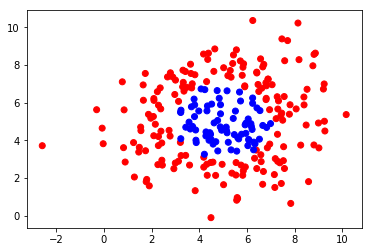

In [15]:
plt.scatter(X_3.x, X_3.y, c=['red' if y == 0 else 'blue' if y == 1 else 'black' for y in Y_3.target])

plt.show()

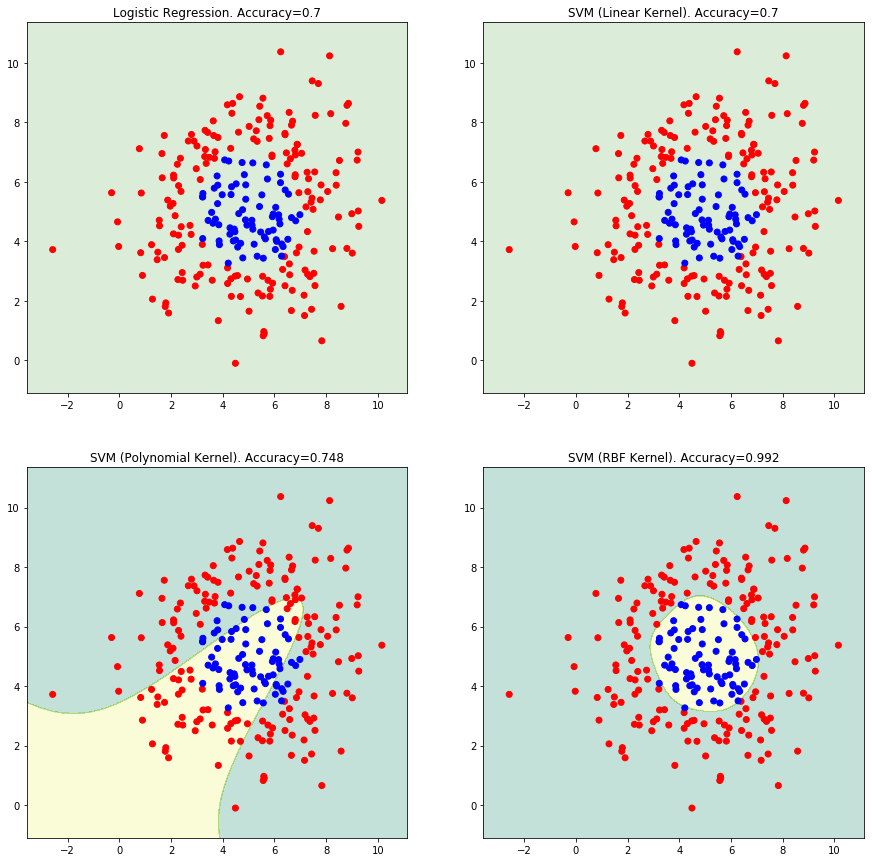

In [16]:
compare_and_plot(X_3, Y_3)

### Выводы

1. Логистическая регрессия и SVM с линейным ядром все точки отнесли к одному классу.

2. У SVM с полиномиальным ядром результат лучше.

3. У SVM с ядром RBF точность максимальна.


## Классы библиотеки scikit-learn

Библиотека предлагает следующие реализации алгоритма SVM:

[LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) - реализация SVM с линейным ядром для задач классификации

[LinearSVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html) - реализация SVM с линейным ядром для задач регрессии

[SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) - наиболее общая реализация SVM для задач классификации

[SVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) - наиболее общая реализация SVM для задач регрессии

[NuSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html) - реализация SVM для задач классификации с возможностью задать количество опорных векторов

[NuSVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVR.html) - реализация SVM для задач регрессии с возможностью задать количество опорных векторов

[OneClassSVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) - реализация SVM для задачи обнаружения отклонений без учителя


## Реальный пример

Попробуем сравнить SVM с линейным ядром и с ядром RBF на реальном примере: [соревновании Титиник](https://www.kaggle.com/c/titanic)

In [17]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score

Считаем данные

In [18]:
X = pd.read_csv("../../data/titanic_train.csv")

y = X['Survived']

Z = pd.read_csv("../../data/titanic_test.csv")

Заполним пропуски

In [19]:
X['Age'].fillna(X['Age'].median(), inplace=True)

X['Embarked'].fillna('S', inplace=True)


Z['Age'].fillna(Z['Age'].median(), inplace=True)

Z['Fare'].fillna(Z['Fare'].median(), inplace=True)

Уберем лишние столбцы

In [20]:
X.drop(['Survived', 'Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, inplace=True)

Z.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, inplace=True)

In [21]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [22]:
y.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [23]:
Z.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


Закодируем признаки `Sex` и `Embarked` при помощи `LabelEncoder`

In [24]:
sex_label_encoder = LabelEncoder().fit(X['Sex'])

X['Sex_num'] = sex_label_encoder.transform(X['Sex'])

X.drop(['Sex'], axis=1, inplace=True)

Z['Sex_num'] = sex_label_encoder.transform(Z['Sex'])

Z.drop(['Sex'], axis=1, inplace=True)


embarked_label_encoder = LabelEncoder().fit(X['Embarked'])

X['Embarked_num'] = embarked_label_encoder.transform(X['Embarked'])

X.drop(['Embarked'], axis=1, inplace=True)

Z['Embarked_num'] = embarked_label_encoder.transform(Z['Embarked'])

Z.drop(['Embarked'], axis=1, inplace=True)

Признаки надо отмасштабировать

In [25]:
scaler = StandardScaler().fit(X)

X_scaled = scaler.transform(X)

Z_scaled = scaler.transform(Z)

Для сравнения моделей будем использовать кросс-валидацию

In [26]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

И наконец, сравним модели на кросс-валидации

In [27]:
logit = LogisticRegression().fit(X_scaled, y)

cross_val_score(logit, X_scaled, y, cv=skf).mean()

0.7934814934603216

In [28]:
linear_svc = LinearSVC().fit(X_scaled, y)

cross_val_score(linear_svc, X_scaled, y, cv=skf).mean()

0.7934563142535234

In [29]:
svm_rbf = SVC(kernel='rbf', class_weight='balanced').fit(X_scaled, y)

cross_val_score(svm_rbf, X_scaled, y, cv=skf).mean()

0.8148050544243235

SVM с ядром RBF показала наилучшие результаты

Сделаем посылку чтобы проверить наше предположение

In [30]:
def write_to_submission_file(predicted_labels, out_file, train_num=891,
                             target='Survived', index_label="PassengerId"):
    
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(train_num + 1,
                                                  train_num + 1 +
                                                  predicted_labels.shape[0]),
                                columns=[target])
    
    predicted_df.to_csv(out_file, index_label=index_label)

In [31]:
write_to_submission_file(logit.predict(Z_scaled), 'titanic_logit.csv')

# Public Score = 0.75119

In [32]:
write_to_submission_file(linear_svc.predict(Z_scaled), 'titanic_linear_svc.csv')

# Public Score = 0.75119

In [33]:
write_to_submission_file(svm_rbf.predict(Z_scaled), 'titanic_svm_rbf.csv')

# Public Score = 0.77511

## Полезные ссылки

http://scikit-learn.org/stable/modules/svm.html

Сравнение SVM и логистический регрессии:
http://www.cs.toronto.edu/~kswersky/wp-content/uploads/svm_vs_lr.pdf
